# Support Vector Machines

In this tutorial, we'll go over the Support Vector Machine (SVM) classification algorithm. The SVM algorithm is a supervised learning algorithm, meaning that we train the SVM on a set of labelled data, which then allows the SVM to predict the labels of future, unlabelled data. Depending on the dataset, SVMs often allow for easier training and more accurate results when compared to other algorithms. By the end of this tutorial, we'll have covered: 
1. The intuition behind what SVMs are really doing.
2. The math behind how SVMs train
3. How SVMs can be extended to a wide variety of nonlinear classification problems. 
4. The practicalities of using SVMs, including processing data and tuning SVMs
5. A fully coded, real world example


## Imports

Let's first import some libraries that we'll need first, and set some defaults for plotting that we'll need later.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.widgets import Slider
import pandas as pd


plt.rcParams["figure.dpi"] = 250
plt.rcParams["figure.figsize"] = [3, 2]
plt.rcParams["font.size"] = 5
plt.rcParams["lines.markersize"] = 5

## Introduction: Linear Classification

We'll start with a mock dataset - a health dataset consisting of data for a bunch of different tumors. We'll actually be working with a real cancer dataset later in this tuturial - but for now, let's work with a mock dataset that I've generated. 

In [10]:
mock_cancer_df = pd.read_csv("mock_cancer_dataset.csv")
mock_cancer_df

,Tumor Area (mm^2),Tumor Perimeter (mm),Diagnosis
0,41.468649,29.753877,Benign
1,50.332586,21.512359,Benign
2,49.859089,22.141659,Benign
3,37.235051,23.268093,Benign
4,54.893690,31.204466,Benign
...,...,...,...
75,104.750442,49.243214,Malignant
76,109.337790,45.113611,Malignant
77,91.930511,48.936299,Malignant
78,96.637698,48.202234,Malignant


We see that the first 2 columns are the **features** of the tumors - namely, the area of the tumor, and the perimeter of the tumor. Meanwhile, the last column is the **target** that we're trying to predict - whether or not the tumor is malignant or benign. The table above is a [pandas](https://pandas.pydata.org/docs/) dataframe - essentially a table with each row being a datapoint, and the columns being different features. Let's first extract this data into [NumPy](https://numpy.org/) arrays:

In [11]:
benign_features = mock_cancer_df[mock_cancer_df["Diagnosis"] == "Benign"].iloc[:, :2].to_numpy()
mal_features = mock_cancer_df[mock_cancer_df["Diagnosis"] == "Malignant"].iloc[:, :2].to_numpy()
feature_1, feature_2 = mock_cancer_df.columns[:2]

NumPy arrays let us work with the dataset with speed and ease. Let's use the plotting library [matplotlib](https://matplotlib.org/stable/tutorials/introductory/quick_start.html#sphx-glr-tutorials-introductory-quick-start-py) to plot this data!

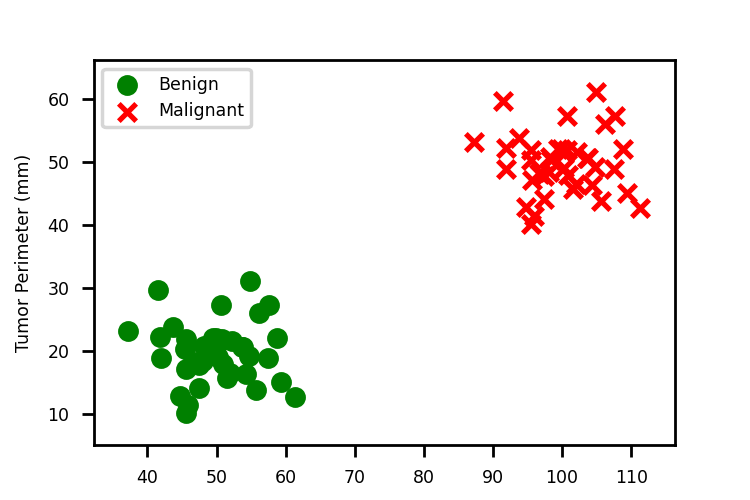

In [12]:
padding = 5
x_lims = np.min(benign_features[:, 0])  - padding, np.max(mal_features[:, 0]) + padding
y_lims = np.min(benign_features[:, 1]) - padding, np.max(mal_features[:, 1]) + padding
x_lims, y_lims = np.array(x_lims), np.array(y_lims)

def scatter_training_set(ax):
    ax.set_xlim(x_lims)
    ax.set_ylim(y_lims)
    ax.set_xlabel(feature_1)
    ax.set_ylabel(feature_2)
    return (ax.scatter(benign_features[:, 0], benign_features[:, 1], c = "green", marker = "o", label = "Benign"),
            ax.scatter(mal_features[:, 0], mal_features[:, 1], c = "red", marker = "x", label = "Malignant"))

fig, ax = plt.subplots()
scatter_training_set(ax)
ax.legend()

Now suppose we're given a new datapoint, for which we don't know whether the point is malignant or benign. The **supervised classification** problem is to use our current labelled dataset to predict the new, unlabelled point.

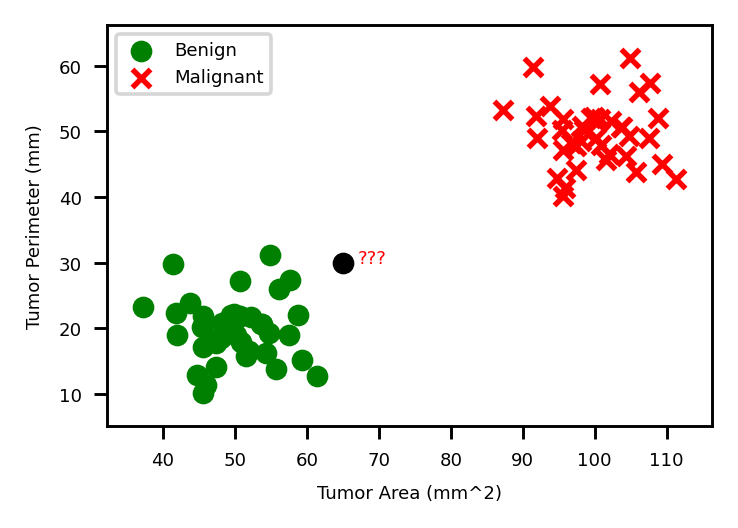

In [13]:
unknown_x, unknown_y = 65, 30
unknown_scatter = ax.scatter(unknown_x, unknown_y, marker = 'o', c = "black")
unknown_annotate = ax.annotate("???", (unknown_x, unknown_y), xytext = (unknown_x + 2, unknown_y), color = "red")
fig

The SVM approach is to make a **separating hyperplane**: a plane that divides the benign and malignant points of our labelled dataset in feature space. In our simple 2d case, that separating hyperplane will just be a line dividing the benign and malignant points. And to make a prediction for the new unlabelled point, we just see what side of the line the point falls on!

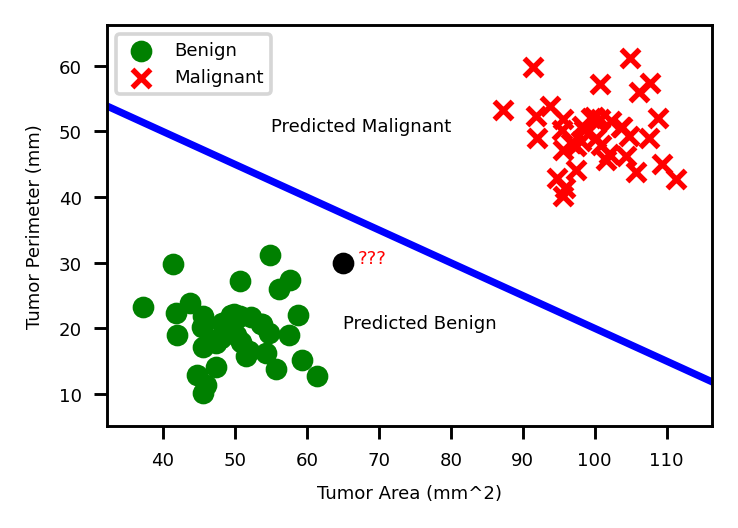

In [14]:
initial_slope = -0.5
initial_intercept = 70
y_line = initial_slope * x_lims + initial_intercept

text_benign = ax.text(65, 20, "Predicted Benign")
text_malignant = ax.text(55, 50, "Predicted Malignant")
line, = ax.plot(x_lims, y_line, lw=2, 
                color='blue', label='Hyperplane')
fig

Now that's great, but we immediately see a problem - there are many different choices of the separating line! You can toggle the sliders in the cell below and see that there are lots of different lines that separate the benign and malignant points - but they'll give different predictions.

0

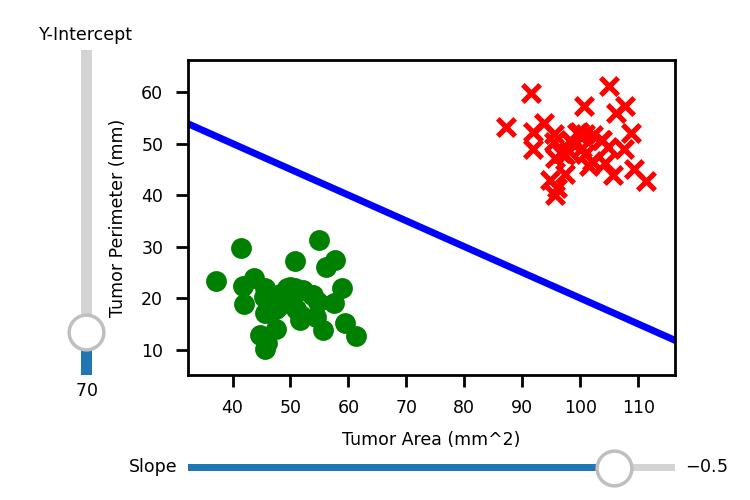

In [15]:
%matplotlib widget
fig, ax = plt.subplots()
fig.subplots_adjust(left=0.25, bottom=0.25)
ax_slope = fig.add_axes([0.25, 0.05, 0.65, 0.03], 
                facecolor='lightgoldenrodyellow')
ax_intercept = fig.add_axes([0.1, 0.25, 0.03, 0.65], 
                        facecolor='lightgoldenrodyellow')
slider_slope = Slider(ax_slope, 'Slope', -4.0, 0.0,
                    valinit=initial_slope)
slider_intercept = Slider(ax_intercept, 'Y-Intercept', 50.0, 200.0, 
                        valinit=initial_intercept, orientation = 'vertical')
scatter_training_set(ax)
line, = ax.plot(x_lims, y_line, lw=2, 
                color='blue', label='Hyperplane')

def set_line_data():
    slope = slider_slope.val
    intercept = slider_intercept.val
    line.set_ydata(slope * x_lims + intercept)

def update(val):
    set_line_data()
    fig.canvas.draw_idle()

slider_slope.on_changed(update)
slider_intercept.on_changed(update)

So which separating line do we choose?
An intuitive solution to this problem is to look for the line that maximizes the distance from the line to the nearest labelled datapoint. This distance is called the **margin**

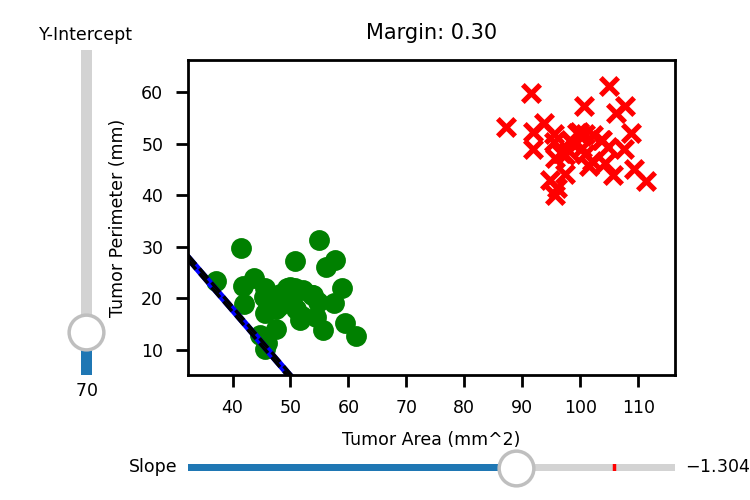

In [16]:
def get_margin(slack_index = -1):
    slope = slider_slope.val
    intercept = slider_intercept.val
    combined_data = np.concatenate((benign_features, mal_features))
    w = np.array([-slope, 1]) / np.sqrt((slope ** 2 + 1))
    scalar_proj = np.sum(combined_data[slack_index + 1:] * w, axis = 1) - intercept * w[1]
    return np.min(np.abs(scalar_proj))

margin_line_upper, = ax.plot(x_lims, [0, 0], lw=1, color='black', label='Hyperplane', linestyle = '--')
margin_line_lower, = ax.plot(x_lims, [0, 0], lw=1, color='black', label='Hyperplane', linestyle = '--')

def set_margin_lines(margin):
    margin_shift = margin * np.sqrt(slider_slope.val**2 + 1)
    margin_line_upper.set_ydata(line.get_ydata() + margin_shift)
    margin_line_lower.set_ydata(line.get_ydata() - margin_shift)

def update(val):
    set_line_data()
    margin = get_margin()
    set_margin_lines(margin)
    ax.set_title(f"Margin: {margin:.2f}")
    fig.canvas.draw_idle()

slider_slope.on_changed(update)
slider_intercept.on_changed(update)
update(0)
plt.show()

Now, let's try to formalize what we've been doing with a bit of math

## All the math you need

All of the concepts above can be formulated using **projections**. The **scalar projection** of vector **a** onto vector **b** is the component of **a** in the direction of **b**: 

![image](Positive_projection.png)

If **a** points in the opposite direction of **b**, the scalar projection is negative:

![image](negative_projection.png)

We can compute the scalar projection as:
$$\frac{\mathbf{a} \cdot \mathbf{b}}{||\mathbf{b}||}$$

Where $||\mathbf{b}||$ is the length of vector **b**. 

How does that help us with classification? Well, let's say we have a point with coordinates $\mathbf{x} = (x_1, x_2)$, and a hyperplane, and we're trying to classify the point:
\
\
<img src="classification_1.png" alt="drawing" width="800"/>

Now, we can of course visually classify the point as above or below the hyperplane - but how can we do so mathematically? One way is to draw the vector **w**, called the **weight vector**, which is **perpendicular** to our hyperplane:
\
\
<img src="classification_2.png" alt="drawing" width="800"/>

And then we can take the scalar projection of **x** onto **w**.
\
\
<img src="classification_3.png" alt="drawing" width="800"/>

And we can see that if the scalar projection of **x** onto **w** is large enough, we can classify **x** as being on the side of the hyperplane that **w** points to - in this case, above the hyperplane. Finally, let's call the distance from the origin along **w** to the hyperplane $b$:
\
\
<img src="classification_4.png" alt="drawing" width="800"/>

And we see that the signed distance from $\mathbf{x}$ to our hyperplane is going to be:

$$\frac{\mathbf{x} \cdot \mathbf{w}}{||\mathbf{w}||} - d$$

This signed distance will be *positive* if it's above the hyperplane, and *negative* if it's below. In other words, taking the sign of $$\frac{\mathbf{x} \cdot \mathbf{w}}{||\mathbf{w}||} - d$$ gives us the classification of the point!

To make this a bit neature, we'll define a variable $b$, called the **bias**, as $d = \frac{-b}{||w||}$. Then 

$$\text{sgn}(\frac{\mathbf{x} \cdot \mathbf{w}}{||\mathbf{w}||} - d) = \text{sgn}(\mathbf{x} \cdot \mathbf{w} + b) $$

Let's review what we just did: in 2 dimensional feature space, we had a 1 dimensional separating hyperplane (a line), and we found that by drawing a 2 dimensional weight vector $\mathbf{w}$, and finding bias $b$, we could compute what side of the hyperplane a point $\mathbf{x}$ falls on. In practice, it's a lot easier to *start* with $\mathbf{w}$ and $b$, and let those define a hyperplane! This also lets us generalize to higher dimensions. In $n$ dimensional space, we'll have an $n$ dimensional weight vector, and a bias $b$, which lets us define an $n-1$ dimensional hyperplane. And we can instantly tell if a point is above or below the hyperplane by computing the sign of $\mathbf{x} \cdot \mathbf{w} + b$. 

If you were paying attention, you might see that computing the margin for a hyperplane is also really easy! Remember, the margin is the distance from the closest point to the hyperplane. But we already found the distance from $\mathbf{x}$ to the hyperplane is $$|\frac{\mathbf{x} \cdot \mathbf{w}}{||\mathbf{w}||} - d|$$ or $$|\frac{\mathbf{x} \cdot \mathbf{w}}{||\mathbf{w}||} + \frac{b}{||w||}|$$

And so the **margin** is just the smallest value of $|\frac{\mathbf{x} \cdot \mathbf{w}}{||\mathbf{w}||} + \frac{b}{||w||}|$ in our labelled dataset!

## Adding some slack

So the point of the support vector machine is to find a separating hyperplane that divides the labelled datapoints according to their labels, while also maximizing the margin - this quantity $\frac{\mathbf{x} \cdot \mathbf{w}}{||\mathbf{w}||} + \frac{b}{||w||}$. But what if we have some rogue datapoints? Let's consider the example below

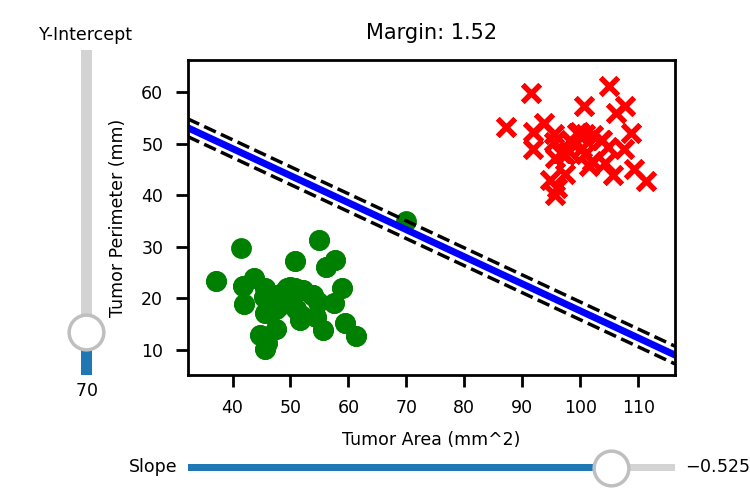

In [17]:
outlier_index = 0
outlier_benign = (70, 35)
benign_features[outlier_index] = outlier_benign
scatter = scatter_training_set(ax)
update(0)
plt.show()

We see that this outlier datapoint is really getting in the way of us having a large margin. In fact, in order for us to maximize the margin, we need to put the hyperplane in between the outlier and the red datapoints - and this doesn't really feel like the correct hyperplane that will actually generalize when we have new data! We need a way to maximize the margin to all of the other points, while taking into account what we're doing with the outlier. 
\
\
The SVM approach is to add what's called **slack**. Essentially, we allow some of our datapoints to fall *inside* of the margin! And the *slack* quantifies exactly how far inside of the margin the point falls. Let's take a look at what this means:

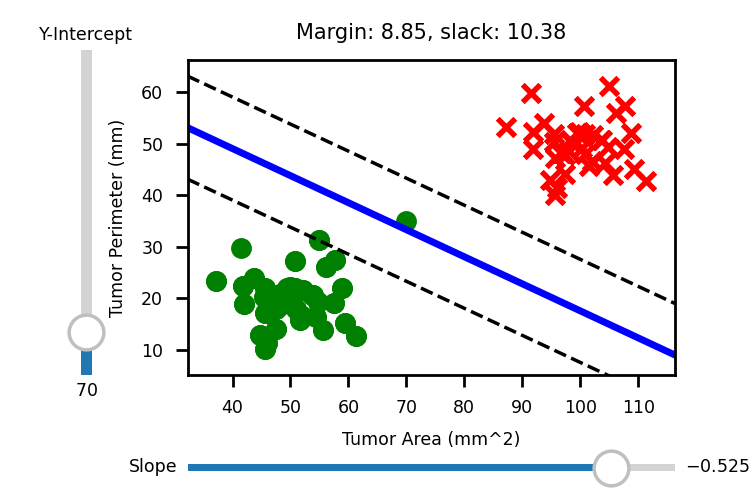

In [18]:
def find_dist_to_outlier(outlier_index):
    w = np.array([-slider_slope.val, 1]) / np.sqrt((slider_slope.val ** 2 + 1))
    return np.sum(benign_features[outlier_index] * w) - slider_intercept.val * w[1] 

def update(val):
    set_line_data()
    margin = get_margin(slack_index = outlier_index)
    set_margin_lines(margin)
    slack = max(margin + find_dist_to_outlier(outlier_index), 0)
    ax.set_title(f"Margin: {margin:.2f}, slack: {slack:.2f}")
    fig.canvas.draw_idle()

slider_slope.on_changed(update)
slider_intercept.on_changed(update)
update(0)
plt.show()

By the way, this means that we have to modify what we mean by the margin - it no longer strictly means the distance from the hyperplane to the closest datapoint. It now means the distance from the hyperplane to the closest datapoint *without slack*. This approach also lets us apply SVMs even when the data might not be linearly seperable: we allow the data that is messing up the seperability to have slack. 

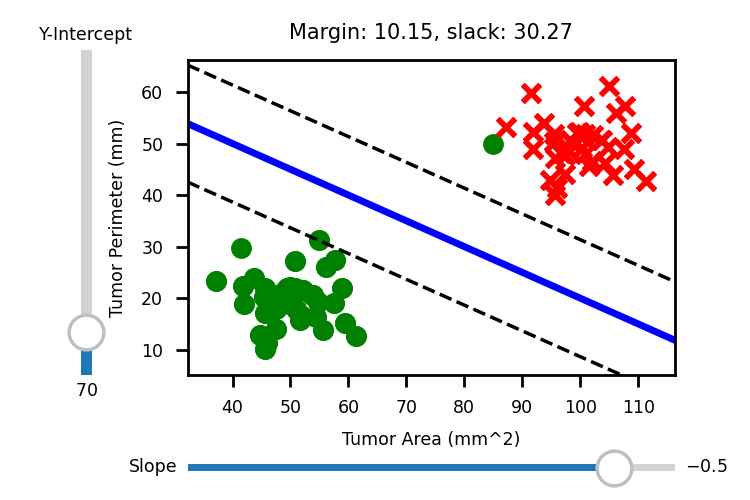

In [19]:
outlier_index = 0
outlier_benign = (85, 50)
benign_features[outlier_index] = outlier_benign
%matplotlib widget
scatter[0].remove()
scatter = scatter_training_set(ax)
update(0)
plt.show()

We see that by allowing the outlier to have slack, we can focus on maximizing the margin to the other data points, and create a more representative hyperplane! If we give the outlier enough slack, we can even allow the outlier to fall on the wrong side of the hyperplane!
\
\
Of course, we can't just aribtrarily allow slack - if we did, then we wouldn't have to correctly divide any data, or maximize any margins! For this reason, SVMs control a tradeoff between slack and maximizing the margin. SVMs work by finding an optimal $\mathbf{w}$ and $b$ that allows us to have large margins on most of the data, while not allowing for too much slack. Essentially, SVMs try to minimize the **cost function**:
$$L(w, b) = [\text{penalty for having small margins}] + C * [\text{penalty for having slack}] $$

This parameter $C$ is super important - it controls how much we care about penalizing slack. Let's consider 2 scenarios:
1. $C$ is super small - close to 0. Then, we really don't penalize slack, and we essentially ignore the points that we misclassify or that are close to the hyperplane. Our slack can be as large as we want!

<img src="large_margin_large_slack.png" alt="drawing" width="600"/>

2. $C$ is super large. Then, we *really* penalize slack, and so we need there to be almost no slack. That means that the SVM will be sensitive to all points in the training data - even outliers. 

<img src="small_margin_small_slack.png" alt="drawing" width="600"/>

$C$ is what is called a *hyperparameter* - a parameter that we don't learn from the training data, but that we need to set before we start training!



## Some Optional Math

In the following section, we'll be formalizing the intuition that we just developed about slack variables. This section is a bit more technical and is optional, but is what you'll often see in machine learning lecture notes.

Let's say that we have a dataset of labelled examples, $S = \{(\mathbf{x}^{(i)}, y^{(i)}); i = 1,...,m\}$, with $\mathbf{x}^{(i)}$ being the features of the ith datapoint, and $y^{(i)}$ being the label of the ith datapoint, which is either $y^{(i)} = 1$ or $y^{(i)} = -1$.

Recall that the *signed* distance from $\mathbf{x}^{(i)}$ to the hyperplane is $\frac{\mathbf{w} \cdot \mathbf{x}^{(i)}}{||\mathbf{w}||} - d = \frac{\mathbf{w} \cdot \mathbf{x}^{(i)}}{||\mathbf{w}||} + \frac{b}{||w||}$. If we have a linearly seperable dataset, that means that the sign of the signed distance will match $y^{(i)}$: negative if $y^{(i)} = -1$, positive if $y^{(i)} = 1$. That means that the actual distance - without the sign - will be:

$$y^{(i)} * (\frac{\mathbf{w} \cdot \mathbf{x}^{(i)}}{||\mathbf{w}||} + \frac{b}{||\mathbf{w}||})$$

<img src="classification_4.png" alt="drawing" width="800"/>


And we can neatly write the margin as:

$$\gamma = \min_{i=1\dots m} y^{(i)} * (\frac{\mathbf{x}^{(i)} \cdot \mathbf{w}}{||\mathbf{w}||} + \frac{b}{||w||})$$

Remember, the goal of the SVM, when we don't allow for slack, is to choose $\mathbf{w}$ and $b$ that will maximize the margin - that is:

$$\text{arg}\max_{\mathbf{w}, b} \gamma$$

Now, you might notice that we actually have freedom to scale $\mathbf{w}$ and $b$. If we replace $\mathbf{w}$ with $2 * \mathbf{w}$, and $b$ with $2b$, we'll end up with the same value of $\gamma$! Intuitively, scaling $w$ and $b$ doesn't actually change the separating hyperplane. For this reason, for a given hyperplane, and linearly separable data, we can always set:

$$\gamma * ||\mathbf{w}|| = 1$$

And so:

$$y^{(i)} * (\mathbf{w} \cdot \mathbf{x}^{(i)} + b) \geq 1$$

And so then for any hyperplane, $\gamma = \frac{1}{||\mathbf{w}||}$, and so our optimization objective is:

$$\text{arg}\max_{w, b} \gamma = \text{arg}\max_{w, b} \frac{1}{||\mathbf{w}||} = \text{arg}\min_{w, b} ||\mathbf{w}||^2$$
$$\text{S.T.   } \mathbf{y^{(i)}} * (\mathbf{w} \cdot \mathbf{x}^{(i)} + b) \geq 1 \text{    for all i}$$

We've transformed our optimization problem into a much easier optimization problem, subject to a constraint (the second line). We just have to find the smallest length $w$ that satisfies the constraint! It turns out that this form of the optimization objective is much easier to solve using standard off-the-shelf algorithms.

We can see how our final expression intuitively makes sense here:

<>:5: SyntaxWarning: invalid escape sequence '\g'
<>:5: SyntaxWarning: invalid escape sequence '\g'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\g'
<>:5: SyntaxWarning: invalid escape sequence '\g'
<>:5: SyntaxWarning: invalid escape sequence '\m'
C:\Users\Jackson\AppData\Local\Temp\ipykernel_23320\1381319506.py:5: SyntaxWarning: invalid escape sequence '\g'
  ax.set_title(f"$\gamma = ${margin:.2f}, need $\gamma * ||\mathbf{{w}}|| = 1$, so $||\mathbf{{w}}|| = {1/margin:.3f}$")
C:\Users\Jackson\AppData\Local\Temp\ipykernel_23320\1381319506.py:5: SyntaxWarning: invalid escape sequence '\g'
  ax.set_title(f"$\gamma = ${margin:.2f}, need $\gamma * ||\mathbf{{w}}|| = 1$, so $||\mathbf{{w}}|| = {1/margin:.3f}$")
C:\Users\Jackson\AppData\Local\Temp\ipykernel_23320\1381319506.py:5: SyntaxWarning: invalid escape sequence '\m'
  ax.set_title(f"$\gamma = ${margin:.2f}, need $\gamma * ||\mathbf{{w}}|| = 1$, so $||\mathbf{{w}}|| = {1/margin:.3f}$"

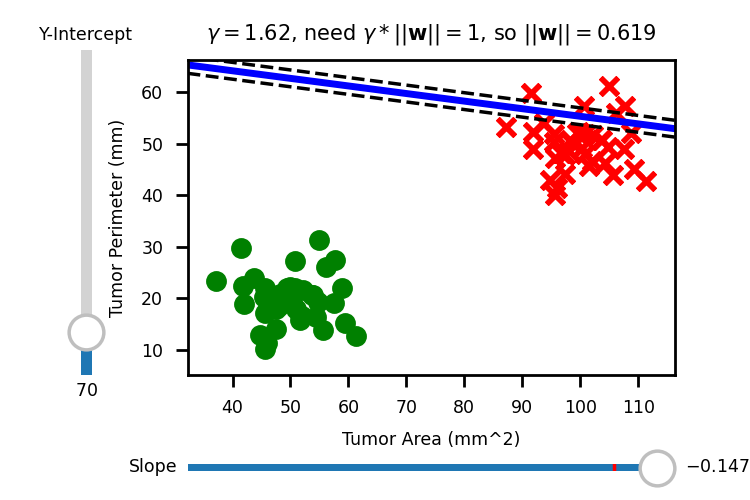

In [20]:
def update(val):
    set_line_data()
    margin = get_margin()
    set_margin_lines(margin)
    ax.set_title(f"$\gamma = ${margin:.2f}, need $\gamma * ||\mathbf{{w}}|| = 1$, so $||\mathbf{{w}}|| = {1/margin:.3f}$")
    fig.canvas.draw_idle()

scatter[0].remove()
slider_slope.on_changed(update)
slider_intercept.on_changed(update)
update(0)
plt.show()

We see that when the hyperplane has a smaller margin, we need a correspondingly larger $\mathbf{w}$ to satisfy the constraint! And by minimizing $\mathbf{w}$, we will indeed find the hyperplane with largest margin. 
\
\
What about slack? Well, remember slack means that we allow some points to fall inside the margin. Mathematically, then, we just allow the point to *violate* that constraint by an amount $\xi_i$, so that we only have to satisfy $y^{(i)} * (\mathbf{w} \cdot \mathbf{x} + b) = 1 - \xi_i$. Of course, the slack $\xi_i$ cannot be negative - if it were, the constraint would be satisfied, and we'd have no need for a slack variable! And so our complete SVM minimization objective is:

$$\text{arg}\min_{w, b} ||\mathbf{w}||^2 + \sum_{i=1}^{m}\xi_i

Now, you might be wondering how the name "Support Vector Machine" comes in. What are support vectors? Well, intuitively, you might realize that the only datapoints that actually determine the value of $\mathbf{w}$ are those that fall on or within the margin - that is, those that contribute to the slack, or those that determine the size of the margin. 

<img src="large_margin_large_slack.png" alt="drawing" width="600"/>

In fact, it turns out that we can always write the optimal set of weights as a linear combination of those points:

$$w^* = \sum_{i=1}^{N} \alpha_i y_i x_i$$

$$\alpha_i > 0 \text{ only for points where } y_i w^* \cdot \mathbf{x}_i + b \leq 1$$ 

That is, the optimal $w$ is a linear combination of datapoints, and that linear combination only consists of points that exactly fall on the margin, or that violate the margin (and thus need slack). These points are called the **support vectors**. They're very useful, since training an SVM involves computing many dot products with $w$. However, writing $w$ in terms of a linear combination of support vectors means that we just have to compute the sum of dot products with the support vectors!

## Kernels

Let's take a second to review what we've covered so far:
1. SVMs are given a set of data, labelled by their corresponding classes. 
2. SVMs draw a hyperplane to separate the data by their class. In order to predict the class of a new datapoint, you just look at what side of the hyperplane that point falls on. 
3. SVMs try to maximize the margin - the distance from the hyperplane to the closest point in the dataset
4. We allow the datapoints to have *slack* and fall inside the margin, so that SVMs work with data that is not perfectly linearly seperable and can maximize the margin to most of the points. 
5. The optimal weights of an SVM are a linear combination of points that fall on and inside the margin - the *support vectors*. Making a prediction with an SVM means taking dot products with the *support vectors*.

But you might be wondering - what if we have dataset that clearly isn't meant to be linearly separated? Consider the following dataset:

In [21]:
num_points = 100
radii = np.random.uniform(1.5, 2.5, num_points)
angles = np.random.uniform(0, 2 * np.pi, num_points)
x = radii * np.cos(angles)
y = radii * np.sin(angles)
X1 = np.column_stack((x, y))

radii = np.random.uniform(0, 1.0, num_points)
angles = np.random.uniform(0, 2 * np.pi, num_points)
x = radii * np.cos(angles)
y = radii * np.sin(angles)
X2 = np.column_stack((x, y))

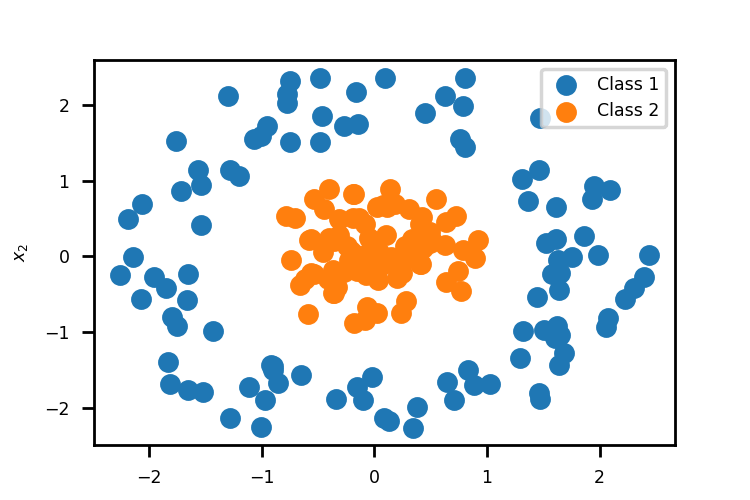

In [22]:
fig, ax = plt.subplots()
ax.scatter(X1[:, 0], X1[:, 1], label = "Class 1")
ax.scatter(X2[:, 0], X2[:, 1], label = "Class 2")
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.legend()

Clearly, this dataset isn't linearly separable - but it is separable by a circle. So what do we do? We can do trick is called *featurization*, where we come up with our own features! In this case, let's try creating 2 new features - $\mathbf{x}_1^2$, and $\mathbf{x}_2^2$:

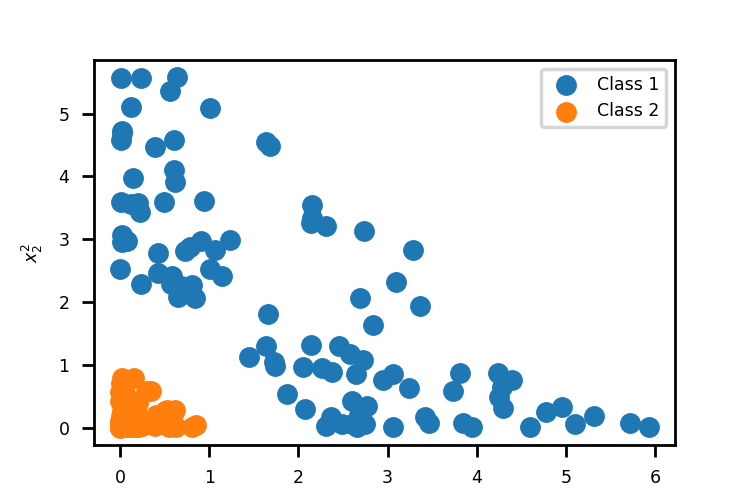

In [23]:
X1_featurized = X1 ** 2
X2_featurized = X2 ** 2
fig, ax = plt.subplots()
ax.scatter(X1_featurized[:, 0], X1_featurized[:, 1], label = "Class 1")
ax.scatter(X2_featurized[:, 0], X2_featurized[:, 1], label = "Class 2")
ax.set_xlabel("$x_1^2$")
ax.set_ylabel("$x_2^2$")
ax.legend()

The data is now linearly separable! So we see that **featurization** lets us transform data that can't be linearly separated into linearly separable data. Formally, we start out with features $\mathbf{x} = [x_1, x_2]$, but then we now work in new feature space $\phi(\mathbf{x}) = [x_1^2, x_2^2]$
\
\
Now, we could go around doing this for every dataset - we could try to come up with a new set of features that makes our dataset linearly separable. Now the problem is that it is really hard to manually featurize, and that if we come up with a whole bunch of new features, we'll need to compute the dot product in that high dimensional space - a highly time consuming process. If we started out with $\mathbf{x}$ in 10 dimensions, and then $\phi(\mathbf{x})$ is in 100 dimensions (which is a realistic scenario), our dot products will take 10 times as long to compute!

Lucky for us, there's a way out! Remember, our goal in an SVM is, for a feature mappings $\mathbf{x} \rightarrow \phi(\mathbf{x})$, to compute $\phi(\mathbf{x}) \cdot \phi(\mathbf{z})$ - the dot product between $\mathbf{x}$ and $\mathbf{y}$ in a new, high dimensional feature space! As it turns out, we can often compute a **kernel**, such that:

$$K(x, z) = \phi(\mathbf{x}) \cdot \phi(\mathbf{z})$$

And this kernel can be computed in the original, low dimensional feature space! For example, it turns out that the kernel between x and z in N dimensional space:

$$K(x, z) = (x \cdot y)^2$$

Is equivalent to taking the dot product between an $N^2$ feature vectors $\phi(\mathbf{x})$ and $\phi(\mathbf{z})$!! So the **kernel trick** is this: for a non-linearly separable dataset, choose a kernel. Then, when we go to compute the dot products between a new point and the support vectors, we instead compute the **kernel** between them. 

There are several popular kernels you'll see. The *Gaussian* kernel is:

$$K(x, z) = exp(-\frac{||x - z||^2}{2\sigma^2})$$

Where $\sigma$ is another **hyperparameter** that we choose! Let's take a look at how using a *Gaussian* kernel will let us create non-linear boundaries around our support vectors:

interactive(children=(FloatSlider(value=1.0, description='w1', max=1.0, min=-1.0), FloatSlider(value=1.0, desc…

<function __main__.plot_contour(w1, w2, w3, b, sigma)>

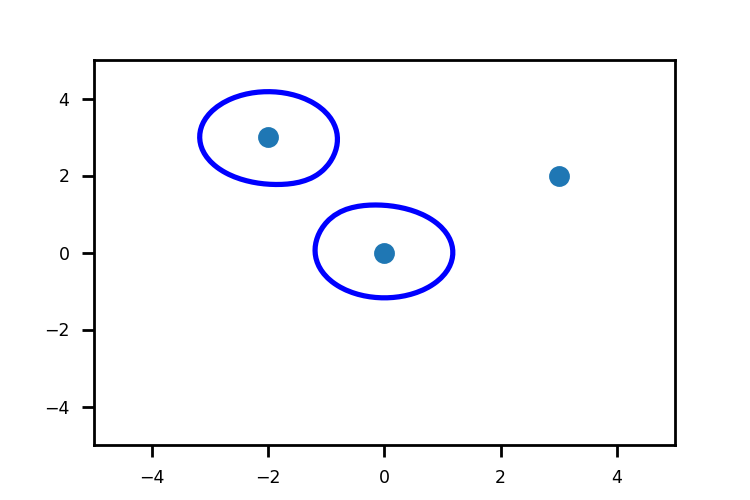

In [24]:
%matplotlib widget
from ipywidgets import interact, FloatSlider
import ipywidgets as widgets
from IPython.display import clear_output

x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
support_vectors = np.array([[-2, 3], [0, 0], [3, 2]])
X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots()

def plot_contour(w1, w2, w3, b, sigma):
    weights = np.array([w1, w2, w3])
    x_diffs = X - support_vectors[:, 0][:, np.newaxis, np.newaxis]
    y_diffs = Y - support_vectors[:, 1][:, np.newaxis, np.newaxis]
    kernels = np.exp((-x_diffs ** 2 - y_diffs ** 2)/(2 * sigma ** 2))
    Z = np.sum(kernels * weights[:, np.newaxis, np.newaxis], 
               axis = 0) + b
    ax.clear()
    ax.scatter(support_vectors[:, 0], support_vectors[:, 1])
    contour = ax.contour(X, Y, Z, 
                          levels=[0], colors='blue')


w1_slider = FloatSlider(value=1.0, min=-1, max=1, step=0.1, description="w1")
w2_slider = FloatSlider(value=1.0, min=-1, max=1, step=0.1, description='w2')
w3_slider = FloatSlider(value=0.0, min=-1, max=1, step=0.1, description='w3')
sigma_slider = FloatSlider(value=1.0, min=0.1, max=5.0, step=0.1, description='sigma')


interact(plot_contour, w1=w1_slider, w2=w2_slider, w3 = w3_slider, b = -0.5, sigma = sigma_slider)

We see that by adjusting the weights and $\sigma$ of our support vector, we are able to create a non-linear decision boundary! We also see that smaller values of $\sigma$ means that the decision boundary is more sensitive to each individual data point, while larger values means that it is less sensitive. This will help us as we adjust our hyperparameters!

## A Fully Coded, Real World Use Case

We now have all the knowledge that we need to apply SVMs to a real world research example! In this example, we'll be working with a real world cancer dataset, which has been used in multiple research papers: The Wisconsin breast cancer datset. 

In [25]:
from sklearn import datasets
cancer = datasets.load_breast_cancer()
df_cancer = pd.DataFrame(np.c_[cancer['data'], cancer['target']], columns = np.append(cancer['feature_names'], ['target']))
df_cancer.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


Our dataset now consists of many more features than just the radius and perimeter. We see that there are 30 features, and we again try to predict the target - whether or not the tumor is malignant or benign. 

The first step of data processing is to store the input features, and the target labels, as [numpy arrays](https://numpy.org/devdocs/user/quickstart.html) - when working with machine learning libraries, this is almost always how data is represented for fast processing. 

In [26]:
X = df_cancer.drop(['target'], axis = 1).to_numpy()
y = df_cancer['target'].to_numpy()

To evaluate how the SVM is doing, we'll first use the SVM to predict the labels of the points in the test set. Then, we'll see how closely those predictions match the actual labels of the testing set - that is, we'll find the **test error**. Scikit-learn, a free machine learning library in python, does a randomized training and testing split for us. 

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

We're giving the SVM the 80 percent of the data as training data, and then making SVM predict the labels of the reamining 20 percent, in order to test how well the SVM performs on data that we've never seen before. 
\
\
The next step is to perform what's called *feature scaling*. Feature scaling means that we'll scale all of the features of our dataset to occupy roughly the same range. This helps the SVM train. To see why feature scaling is important, imagine you had one feature that ranged from 0 to 1000, and another feature from 0 to 1, and the 2 features are equally important in determning the separating hyperplane. In this case, the SVM will need to find weights that differ roughly 1000 times in magnitude in order to capture the fact that the features are equally important. While the SVM will be able to do this, this will make training the SVM more time consuming. 
\
\
Luckily, Scikit-learn does feature scaling for us! We'll use the StandardScaler to shift each feature to have mean 0 and standard deviation 1. 

In [28]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Notice a slightly subtle point here: we fit *and* transform training data - that is, we decide how much to shift and scale each feature based on the training data (fitting), before actually applying that shifting and scaling (transforming). However, when we have test data, we only *transform* the test data. This is because we want to act like we've never seen the test data when we train our model, and thus don't use the information from the test set to determine the feature scaling. Remember, the goal is to test how well the SVM will generalize to new data that we've never seen before - and when we really have new data, we won't be able to access the data beforehand to help determing the feature scaling!

Now, let's see how the SVM with a Gaussian kernel, and C = 1 and and $\gamma = 1$, is trained on the training set!

In [29]:
from sklearn.svm import SVC
clf = SVC(kernel = 'rbf', C = 1, gamma = 0.2)
clf.fit(X_train_scaled, y_train)

SVC(C=1, gamma=0.2)

And let's see how the SVM makes predictions on the training set!

In [30]:
test_predictions = clf.predict(X_test_scaled)
test_predictions

array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1.,
       0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0.,
       0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0.,
       1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1.,
       1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1.])

And we can look at the **accuracy** of the predictions - what percentage of the times the SVM predicts the correct classification on the test set!

In [31]:
from sklearn import metrics
print("Accuracy:", metrics.accuracy_score(y_test, test_predictions))

Accuracy: 0.9385964912280702


Besides accuracy, we can also look at 2 other metrics - the **precision** and the **recall**. The **precision** is defined as the total number of times that the ML algorithm correctly predicted a positive class - in our case, that a tumor is malignant - divided by the total number of times that an ML algorithm predicted a positive class. In other words, the precision tells us how often predictions of a tumor being malignant are correct. 

Meanwhile, the **recall** is defined by the total number of times that the ML algorithm correctly predicted a positive class divided by the total number of positive cases. In other words, the **recall** tells us how often malignant tumors are correctly identified by the SVM. 

In [32]:
print("PRECISION:", metrics.precision_score(y_test, test_predictions))
print("Recall:", metrics.recall_score(y_test, test_predictions))

PRECISION: 0.9545454545454546
Recall: 0.9402985074626866


## Hyperparameter Tuning

Now it's great that we can get pretty good predictions - but we just guessed values of C and $\gamma$. How can we find the best values of C and $\gamma$ - in other words, how can we tune our hyperparameters?

We could see one possible way that we could do this - we could try out different values of C and $\gamma$ until we find one that maximizes the test accuracy. So we deliver the best test accuracy, and we've optimized our SVM algorithm! Right?

The problem with the above approach is that we've cheated - we're *using* the testing set to tune the value of k. Therefore, the test error no longer faithfully represents how well the algorithm performs on new, unseen data - we've already used the testing set to fit C and $\gamma$. 

We can remedy this by further splitting the training set into training and **validation** sets. We'll first try to predict the labels of the *validation* set, and use this to tune C and $\gamma$. Once we find a good value of C and $\gamma$, we'll use the testing set to get an unbiased evaluation of the SVM performance. 

![Training, Validation, and Testing Image](https://b1739487.smushcdn.com/1739487/wp-content/uploads/2021/04/train-and-test-1-min-1.png?lossy=0&strip=1&webp=1)

In fact, since our dataset is rather small, we don't have to just do the validation on a single split of training and validation. For a given value of C and $\gamma$ We can do it several times, each time using a different part of the original training set as the validation set. This is called k-fold cross validation:

![K-fold cross validation](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/K-fold_cross_validation_EN.svg/521px-K-fold_cross_validation_EN.svg.png?20190918162000)

The good news is that Scikit-learn does cross validation for us! And what's more, since each time we get a new training and validation split, we also need to refit the StandardScaler, Scikit-learn lets us combine the scaler and the SVM into a **pipeline**.

In [33]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
clf = Pipeline([('Scaler', StandardScaler()),
                ('Estimator', SVC(kernel = 'rbf', C = 1, gamma = 0.2))])
scores = cross_val_score(clf, X_train, y_train, cv=5)
print(f"Cross validation scores: {scores}")
print(f"Mean score: {np.mean(scores)}")

Cross validation scores: [0.94505495 0.94505495 0.89010989 0.96703297 0.95604396]
Mean score: 0.9406593406593406


Of course, all this cross validation only occurs for a single set of C and $\gamma$. We want to try it out for a bunch of different values of C and $\gamma$!

In [34]:
## Cross validation
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

best_C = -1
best_gamma = -1
best_accuracy = 0
for C in [0.01, 0.1, 1, 10, 20, 30]:
    for gamma in [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]:
        clf = Pipeline([('Scaler', StandardScaler()),
                        ('Estimator', SVC(kernel = "rbf", C = C, gamma = gamma, random_state = 42))])
        scores = cross_val_score(clf, X_train, y_train, cv=5)
        mean_score = np.mean(scores)
        if mean_score > best_accuracy:
            best_C = C
            best_gamma = gamma
            best_accuracy = mean_score
        print(f"C = {C}, gamma = {gamma}:")
        print(f"Cross validation scores: {scores}")
        print(f"Mean score: {mean_score} \n")

C = 0.01, gamma = 0.01:
Cross validation scores: [0.63736264 0.63736264 0.63736264 0.63736264 0.63736264]
Mean score: 0.6373626373626373 

C = 0.01, gamma = 0.02:
Cross validation scores: [0.63736264 0.63736264 0.63736264 0.63736264 0.63736264]
Mean score: 0.6373626373626373 

C = 0.01, gamma = 0.05:
Cross validation scores: [0.63736264 0.63736264 0.63736264 0.63736264 0.63736264]
Mean score: 0.6373626373626373 

C = 0.01, gamma = 0.1:
Cross validation scores: [0.63736264 0.63736264 0.63736264 0.63736264 0.63736264]
Mean score: 0.6373626373626373 

C = 0.01, gamma = 0.2:
Cross validation scores: [0.63736264 0.63736264 0.63736264 0.63736264 0.63736264]
Mean score: 0.6373626373626373 

C = 0.01, gamma = 0.5:
Cross validation scores: [0.63736264 0.63736264 0.63736264 0.63736264 0.63736264]
Mean score: 0.6373626373626373 

C = 0.01, gamma = 1:
Cross validation scores: [0.63736264 0.63736264 0.63736264 0.63736264 0.63736264]
Mean score: 0.6373626373626373 

C = 0.1, gamma = 0.01:
Cross vali

In [35]:
print(f"Best C: {best_C}, best gamma: {best_gamma}, best accuracy: {best_accuracy}")

Best C: 10, best gamma: 0.01, best accuracy: 0.9846153846153847


Now that we've found the best hyperparameters through cross validation, we can go ahead and train the SVM with the best hyperparameters on the full training set, and use it to predict the labels of the test set!

In [36]:
clf = SVC(kernel="rbf", C = 10, gamma = 0.01)
clf.fit(X_train_scaled, y_train)
test_predictions = clf.predict(X_test_scaled)


In [37]:
print("Accuracy:", metrics.accuracy_score(y_test, test_predictions))
print("PRECISION:", metrics.precision_score(y_test, test_predictions))
print("Recall:", metrics.recall_score(y_test, test_predictions))

Accuracy: 0.9824561403508771
PRECISION: 0.9850746268656716
Recall: 0.9850746268656716


## When to use an SVM

SVMs are often faster to train than more complicated classification algorithms, such as neural networks. For this reason, SVMs are often useful on **small** or **intermediate** sized datasets. Once the datasets become larger, however, SVMs can become more expensive. This is because **training** an SVM requires that we compute the kernel between each one of our datapoints, which takes time that goes as the squared of the number of datapoints! 

## Conclusion

In this lecture, we went over the intuition, mathematics, and practicalities of using SVMs. While there is still more to be said about how exactly SVMs are optimized (see Andrew Ng's [excellent lecture notes](https://see.stanford.edu/materials/aimlcs229/cs229-notes3.pdf) if you're curious), I hope that this tutorial provides you with enough knowledge to confidently use SVMs, and know what the SVM is really trying to accomplish! So go forth, and have fun classifying! 